In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, measure
from matplotlib import cm, colors
from matplotlib.collections import LineCollection
from scipy.sparse import load_npz
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import load_npz, issparse
from skimage import io, measure
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors, cm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors, cm
from skimage import measure
from skimage.segmentation import find_boundaries
%matplotlib inline

In [2]:
he_image_path = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.tiff"
labels_npz_path = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.npz"
adata_path = "/gpfs/commons/groups/innovation/share/10X_VisiumHD_CRC/adata/annotated_b2c_adatas/P2_CRC_annotated.h5ad"

In [3]:
adata = sc.read_h5ad(adata_path)

In [4]:
adata.obs

object_id  bin_count    array_row    array_col labels_joint_source  \
1             1.0       20.0  2503.750000   482.100000             primary   
2             2.0       20.0  2488.000000   459.900000             primary   
3             3.0       42.0  2472.238095   102.309524             primary   
4             4.0       14.0  2492.357143   489.928571             primary   
5             5.0       25.0  2497.240000   462.440000             primary   
...           ...        ...          ...          ...                 ...   
247358   247358.0        7.0   288.000000  3158.714286             primary   
247359   247359.0       18.0   199.277778  3341.722222             primary   
247360   247360.0       61.0   460.508197  3232.573770             primary   
247361   247361.0        4.0    90.000000  3136.500000             primary   
247362   247362.0        9.0    34.666667  3107.222222             primary   

       source      predicted_ClusterFull predicted_ClusterTop  \
1       query  Tumor cE01 (Stem/TA-like)                  Epi   
2       query          cS28 (GREM1+ CAF)                Strom   
3       query  Tumor cE01 (Stem/TA-like)                  Epi   
4       query           cP2 (Plasma IgG)               Plasma   
5       query          cS28 (GREM1+ CAF)                Strom   
...       ...                        ...                  ...   
247358  query            cM01 (Monocyte)              Myeloid   
247359  query      cTNI14 (CD8+ CXCL13+)               TNKILC   
247360  query  Tumor cE01 (Stem/TA-like)                  Epi   
247361  query           cTNI20 (PLZF+ T)               TNKILC   
247362  query  Tumor cE01 (Stem/TA-like)                  Epi   

       predicted_ClusterMidway  
1                         EpiT  
2                        Fibro  
3                         EpiT  
4                       Plasma  
5                        Fibro  
...                        ...  
247358                    Mono  
247359                    TCD8  
247360                    EpiT  
247361                 TZBTB16  
247362                    EpiT  

[240708 rows x 9 columns]

In [72]:
# Load H&E image and segmentation labels
he_img = io.imread(he_image_path)
labels_sparse = load_npz(labels_npz_path)
H, W = labels_sparse.shape

In [73]:
print(adata.obs.columns)
print(adata.obsm.keys())

Index(['object_id', 'bin_count', 'array_row', 'array_col',
       'labels_joint_source', 'source', 'predicted_ClusterFull',
       'predicted_ClusterTop', 'predicted_ClusterMidway'],
      dtype='object')
KeysView(AxisArrays with keys: X_pca, X_pca_harmony, X_umap, spatial, spatial_cropped_150_buffer)


In [74]:
print(adata.obsm.keys())
#  Filter High-Expressing Cells 
# Pick the gene of interest
gene = "COL1A1"
expr_quantile = 0.95  # top 5% for high-expressing cells

# Get gene expression values for the selected gene
Xg = adata[:, gene].X
try:
    Xg = Xg.toarray()
except Exception:
    pass
Xg = np.asarray(Xg).ravel()

# Apply the expression quantile filter
thr = np.quantile(Xg, expr_quantile)
high_expr_mask = Xg > thr
high_expr_cells = adata[high_expr_mask]

# Get the coordinates of the high-expressing cells (centroids) from spatial
xy = adata.obsm["spatial"]  # Get spatial coordinates (x, y)
rows_all = np.rint(xy[:, 1]).astype(int)  # 'y' coordinate is in column 1
cols_all = np.rint(xy[:, 0]).astype(int)  # 'x' coordinate is in column 0


KeysView(AxisArrays with keys: X_pca, X_pca_harmony, X_umap, spatial, spatial_cropped_150_buffer)


In [57]:
#This does it for the entire image will crash run as seperate run 

# #  Find Nuclei Under Each Cell 
# # Helper function to get label under each cell's centroid
# def get_label_for_cell(row, col, labels):
#     try:
#         return labels[row, col]
#     except IndexError:
#         return 0  # If the cell is out of bounds

# # Get labels for the high-expressing cells (cell centroids)
# labels_for_cells = [get_label_for_cell(row, col, labels_sparse.toarray()) for row, col in zip(rows_all[high_expr_mask], cols_all[high_expr_mask])]
# unique_labels = np.unique(labels_for_cells)
# unique_labels = unique_labels[unique_labels > 0]  # Remove background label (0)

# #  Visualize the Segmented Nuclei and Gene Expression
# # Plot the segmented nuclei and highlight high-expressing cells
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(he_img)

# # Find contours of the segmented nuclei (labels)
# lines = []
# for lbl in unique_labels:
#     for c in measure.find_contours(labels_sparse.toarray() == lbl, 0.5):
#         lines.append(np.column_stack((c[:, 1], c[:, 0])))  # Convert (row, col) to (x, y)

# # Draw the contours (outlines of the nuclei)
# ax.add_collection(LineCollection(lines, colors='yellow', linewidths=1.0))

# # Scatter high-expressing cell centroids (color them by expression)
# expr_values = Xg[high_expr_mask]
# ax.scatter(cols_all[high_expr_mask], rows_all[high_expr_mask], c=expr_values, cmap='viridis', s=20, edgecolors='cyan', linewidths=0.5)

# # Add colorbar
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=expr_values.min(), vmax=expr_values.max()))
# sm.set_array([])  # Empty array for colorbar
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label(f"{gene} Expression")

# # Title and axis labels
# ax.set_title(f"{gene} Expression and Segmented Nuclei")
# ax.set_xticks([]); ax.set_yticks([])  # Hide axis ticks for better visualization

# # Show the plot
# plt.tight_layout()
# plt.show()

KeyboardInterrupt: 

In [75]:
#Class
class B2CContext:
    """
    Wraps: H&E image (RGB), StarDist label image (sparse .npz of ints), and AnnData.
    Provides pixel-aligned centroids and object_id vector
    """
    def __init__(self, he_image_path, labels_npz_path, adata_path):
        self.adata  = sc.read_h5ad(adata_path)
        self.he     = io.imread(he_image_path)
        self.lab_sp = load_npz(labels_npz_path)  # sparse int labels

        H, W = self.lab_sp.shape
        assert self.he.shape[:2] == (H, W), f"Image/labels mismatch: H&E {self.he.shape[:2]} vs {H,W}"

        # Prefer cropped pixel coords if present, else raw 'spatial'
        if "spatial_cropped_150_buffer" in self.adata.obsm:
            xy = self.adata.obsm["spatial_cropped_150_buffer"]  # (x,y)
            source = "obsm['spatial_cropped_150_buffer']"
        elif "spatial" in self.adata.obsm:
            xy = self.adata.obsm["spatial"]
            source = "obsm['spatial']"
        else:
            raise KeyError("No pixel coords found in adata.obsm (need 'spatial' or 'spatial_cropped_150_buffer').")

        self.cols = np.rint(xy[:, 0]).astype(int)
        self.rows = np.rint(xy[:, 1]).astype(int)
        self.cols = np.clip(self.cols, 0, W-1)
        self.rows = np.clip(self.rows, 0, H-1)
        self.coord_source = source

        # object IDs if you want to compare methods
        self.obj_ids = self.adata.obs["object_id"].to_numpy().astype(int) if "object_id" in self.adata.obs else None

    @property
    def shape(self):
        return self.lab_sp.shape  # (H, W)

    def crop_rc(self, r0, r1, c0, c1):
        """Return H&E crop and DENSE label crop for [r0:r1, c0:c1]."""
        he  = self.he[r0:r1, c0:c1]
        lab = self.lab_sp[r0:r1, c0:c1].toarray()
        return he, lab


def make_tiles(ctx: B2CContext, tile_h=1500, tile_w=1500, stride_h=None, stride_w=None):
    H, W = ctx.shape
    stride_h = tile_h if stride_h is None else stride_h
    stride_w = tile_w if stride_w is None else stride_w
    tiles, tid = [], 0
    r = 0
    while r < H:
        r1 = min(r + tile_h, H)
        c = 0
        while c < W:
            c1 = min(c + tile_w, W)
            tiles.append(dict(id=tid, r0=r, r1=r1, c0=c, c1=c1))
            tid += 1
            if c1 == W: break
            c += stride_w
        if r1 == H: break
        r += stride_h
    return tiles


def show_tile_grid_numbers(ctx: B2CContext, tiles, downsample=8, fontsize=10):
    H, W = ctx.shape
    thumb = ctx.he[::downsample, ::downsample]
    fig, ax = plt.subplots(figsize=(10, 10 * H / W))
    ax.imshow(thumb)
    for t in tiles:
        r0, r1 = t["r0"] // downsample, t["r1"] // downsample
        c0, c1 = t["c0"] // downsample, t["c1"] // downsample
        ax.plot([c0, c1, c1, c0, c0], [r0, r0, r1, r1, r0], color="white", linewidth=0.6)
        ax.text((c0 + c1) / 2, (r0 + r1) / 2, str(t["id"]), color="white",
                fontsize=fontsize, ha="center", va="center")
    ax.set_title(f"Tile grid (downsample={downsample}x). Slide size H×W = {H}×{W}\ncoords from {ctx.coord_source}")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()


def tiles_to_table(tiles, csv_path=None):
    df = pd.DataFrame(tiles)[["id", "r0", "r1", "c0", "c1"]].sort_values("id").reset_index(drop=True)
    if csv_path: df.to_csv(csv_path, index=False)
    return df


def dense_gene(adata, gene):
    if gene not in adata.var_names:
        raise ValueError(f"{gene} not in adata.var_names.")
    Xg = adata[:, gene].X
    if issparse(Xg):
        Xg = Xg.toarray()
    return np.asarray(Xg).ravel()


def draw_all_boundaries(ctx: B2CContext, tile, edge_thickness=1):
    r0, r1, c0, c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    he, lab = ctx.crop_rc(r0, r1, c0, c1)
    from scipy.ndimage import binary_dilation

    edges = find_boundaries(lab, mode="inner")
    if edge_thickness > 1:
        edges = binary_dilation(edges, iterations=edge_thickness-1)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(he)
    ax.imshow(edges, alpha=0.9)
    ax.set_title(f"Tile {tile['id']} — all nuclei boundaries")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()


def tile_gene_centroid_map(ctx: B2CContext, tile, gene,
                           expr_quantile=0.95, top_n=None,
                           mode="outline",  # outline' or fill
                           search_radius=1,  # small neighborhood to catch centroid on 0
                           cmap_name="viridis",
                           outline_width=1.2,
                           make_barplot=True):
    """
    Tile-only pipeline:
      1) crop H&E and label tile
      2) filter cells in tile and by expression quantile
      3) map each kept cell to the label under its centroid (with small neighborhood search)
      4) aggregate per-label expression (max per label)
      5) render overlay + optional ranked bar plot
    """
    r0, r1, c0, c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    he, lab = ctx.crop_rc(r0, r1, c0, c1)
    present = np.unique(lab); present = present[present > 0]
    if present.size == 0:
        raise RuntimeError("No labels in this tile.")

    Xg = dense_gene(ctx.adata, gene)

    # in-tile cells by centroid
    in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
    if not np.any(in_tile):
        raise RuntimeError("No cells (centroids) in this tile region.")

    # expression filter
    keep = in_tile.copy()
    if expr_quantile is not None:
        thr = np.quantile(Xg[in_tile], expr_quantile)
        keep &= (Xg > thr)

    rows_k = ctx.rows[keep] - r0
    cols_k = ctx.cols[keep] - c0
    vals_k = Xg[keep]

    # map centroid -> label with a tiny local search if the exact pixel is background
    def nearest_label(rr, cc):
        lbl = lab[rr, cc]
        if lbl > 0 or search_radius <= 0:
            return lbl
        rr0 = max(rr - search_radius, 0); rr1 = min(rr + search_radius + 1, lab.shape[0])
        cc0 = max(cc - search_radius, 0); cc1 = min(cc + search_radius + 1, lab.shape[1])
        sub = lab[rr0:rr1, cc0:cc1]
        nz = sub[sub > 0]
        if nz.size == 0:
            return 0
        return np.bincount(nz).argmax()

    # aggregate per-label (max expression)
    lab_expr = {}
    for rr, cc, v in zip(rows_k, cols_k, vals_k):
        if rr < 0 or cc < 0 or rr >= lab.shape[0] or cc >= lab.shape[1]:
            continue
        lbl = nearest_label(rr, cc)
        if lbl <= 0:
            continue
        if (lbl not in lab_expr) or (v > lab_expr[lbl]):
            lab_expr[lbl] = v

    if not lab_expr:
        raise RuntimeError("No labels passed the filter in this tile (after centroid→label mapping).")

    # Rank labels by expression and pick top_n if requested
    ranked = np.array(sorted(lab_expr, key=lab_expr.get, reverse=True), dtype=int)
    if top_n is not None:
        ranked = ranked[:top_n]
    vals = np.array([lab_expr[l] for l in ranked], dtype=float)

    # robust color scale
    vmin, vmax = (np.percentile(vals, 2), np.percentile(vals, 98)) if vals.size > 5 else (vals.min(), vals.max())
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    # overlay
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(he)

    if mode == "fill":
        lut = np.full(int(lab.max()) + 1, np.nan, dtype=float)
        for lbl in ranked: lut[lbl] = lab_expr[lbl]
        expr_img = lut[lab]
        im = ax.imshow(expr_img, cmap=cmap, norm=norm, alpha=0.45)
        cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02); cb.set_label(f"{gene} (max per label)")
    elif mode == "outline":
        lines, line_colors = [], []
        for lbl in ranked:
            rr, cc = np.where(lab == lbl)
            if rr.size == 0: continue
            rmin, rmax = rr.min(), rr.max() + 1
            cmin, cmax = cc.min(), cc.max() + 1
            roi = (lab[rmin:rmax, cmin:cmax] == lbl)
            for c in measure.find_contours(roi, 0.5):
                c[:, 0] += rmin; c[:, 1] += cmin
                lines.append(np.column_stack((c[:, 1], c[:, 0])))
                line_colors.append(cmap(norm(lab_expr[lbl])))
        if lines:
            ax.add_collection(LineCollection(lines, colors=line_colors, linewidths=outline_width))
        sm = cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
        cb = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02); cb.set_label(f"{gene} (max per label)")
    else:
        raise ValueError("mode must be 'outline' or 'fill'.")

    # plot centroids kept optional visual sanity
    ax.scatter(cols_k, rows_k, s=6, facecolors='none', edgecolors='cyan', linewidths=0.6)

    ax.set_title(f"Tile {tile['id']} — {gene} ({len(ranked)} labels shown; q={expr_quantile})")
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()

    #  optional bar plot (ranked labels) 
    if make_barplot:
        fig2, ax2 = plt.subplots(figsize=(6, max(2, 0.2*len(ranked))))
        order = np.argsort(vals)[::-1]
        ax2.barh([str(ranked[i]) for i in order], vals[order])
        ax2.invert_yaxis()
        ax2.set_xlabel(f"{gene} (max per label)")
        ax2.set_ylabel("Label (StarDist ID)")
        ax2.set_title(f"Tile {tile['id']} — ranked labels by {gene}")
        plt.tight_layout(); plt.show()

    # return table
    df = pd.DataFrame({"label": ranked, f"{gene}_max": vals})
    return df


def overlay_tile_quick(ctx, tiles, tile_id, gene, expr_q=0.95, top_n=500, mode="outline"):
    tile = next(t for t in tiles if t["id"] == tile_id)
    draw_all_boundaries(ctx, tile, edge_thickness=2)
    return tile_gene_centroid_map(ctx, tile, gene, expr_quantile=expr_q, top_n=top_n, mode=mode)


In [76]:
ctx = B2CContext(
    he_image_path   = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.tiff",
    labels_npz_path = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.npz",
    adata_path      = "/gpfs/commons/groups/innovation/share/10X_VisiumHD_CRC/adata/annotated_b2c_adatas/P2_CRC_annotated.h5ad",
)
print("Slide shape (H,W):", ctx.shape, "| coords:", ctx.coord_source)

Slide shape (H,W): (20852, 22785) | coords: obsm['spatial_cropped_150_buffer']


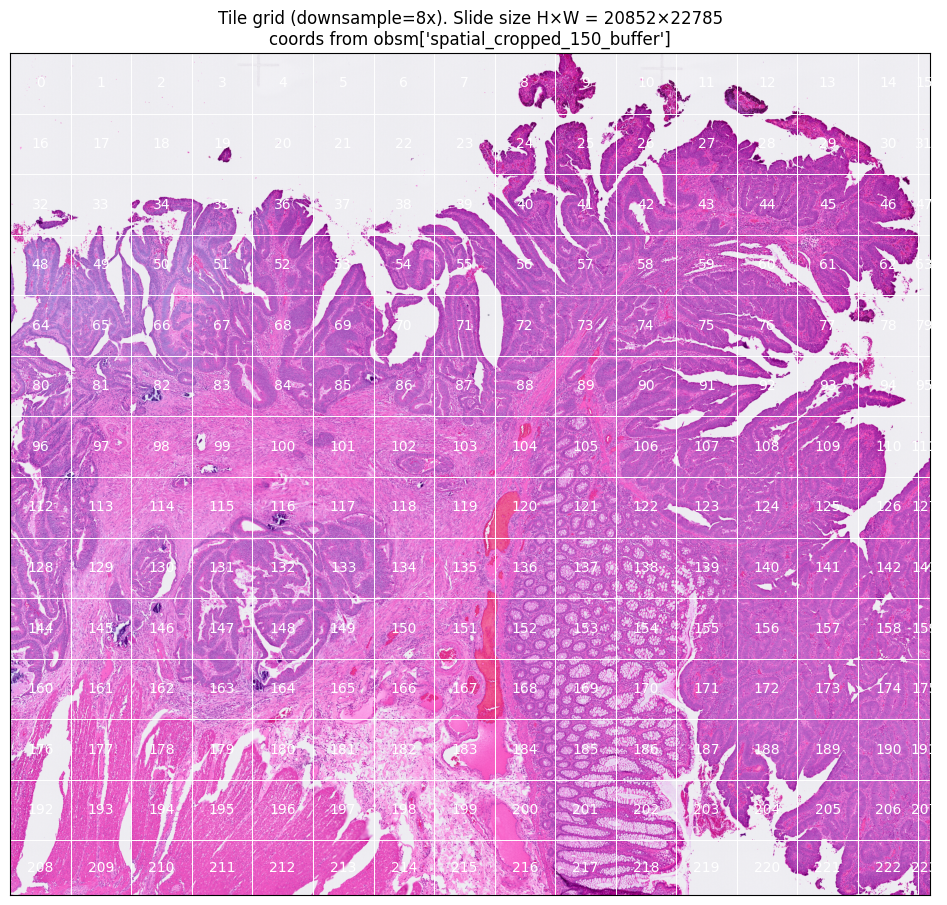

In [77]:
tiles = make_tiles(ctx, tile_h=1500, tile_w=1500, stride_h=1500, stride_w=1500)
show_tile_grid_numbers(ctx, tiles, downsample=8, fontsize=10)

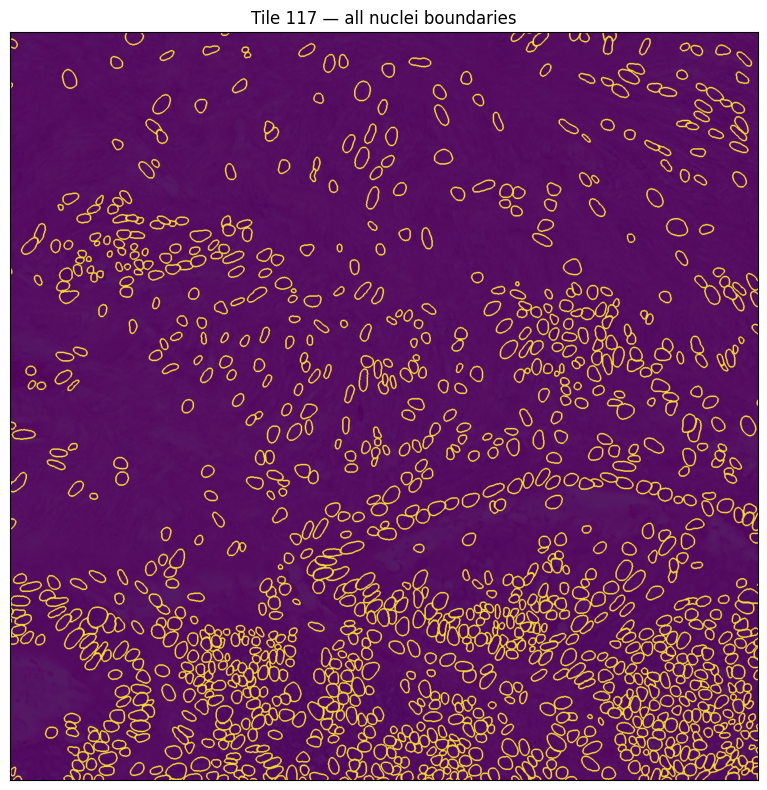

/tmp/ipykernel_3379477/4267253010.py:187: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


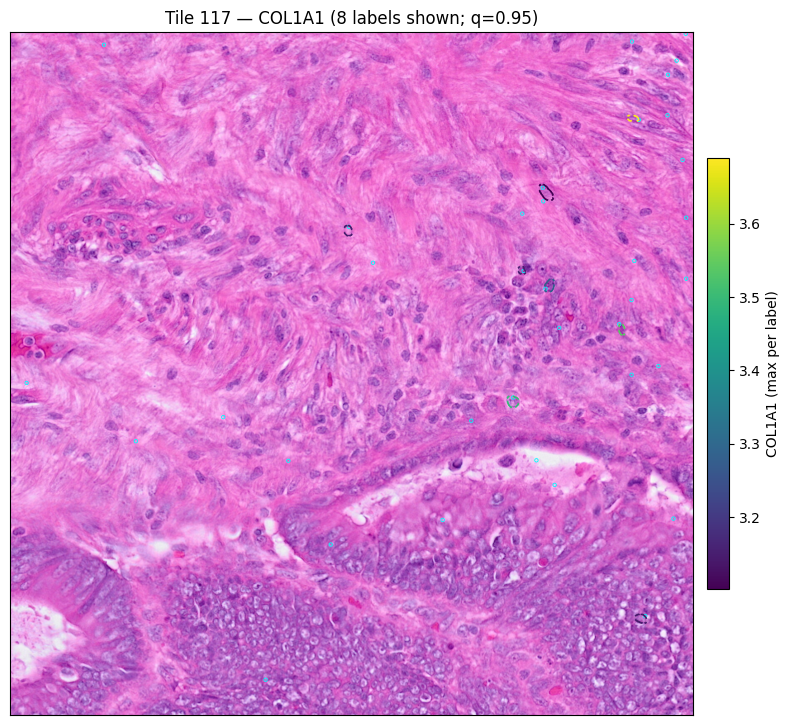

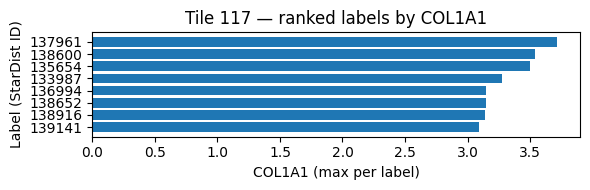

label  COL1A1_max
0  137961    3.713650
1  138600    3.540036
2  135654    3.496339
3  133987    3.272129
4  136994    3.149700

In [78]:
df_ranked = overlay_tile_quick(ctx, tiles, tile_id=117, gene="COL1A1",
                               expr_q=0.95, top_n=500, mode="outline")
df_ranked.head()


In [79]:
def tile_gene_all_boundaries(ctx: B2CContext, tile, gene,
                             expr_quantile=0.90,    # loosen if too few highlights
                             top_n=None,
                             mode="outline",        # outline or fill
                             search_radius=2,       # helps if centroid hits background
                             all_edges_color="lightgray",
                             all_edges_alpha=0.6,
                             all_edges_width=0.5,
                             highlight_color="lime",
                             highlight_width=2.5,
                             cmap_name="viridis",
                             show_centroids=False):
    """
    H&E background + ALL nuclei boundaries (light gray) + gene-positive nuclei highlighted.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    from matplotlib import colors, cm
    from skimage import measure
    from skimage.segmentation import find_boundaries

    r0,r1,c0,c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    he, lab = ctx.crop_rc(r0, r1, c0, c1)
    present = np.unique(lab); present = present[present > 0]
    if present.size == 0:
        raise RuntimeError("No labels in this tile.")

    # dense gene vector
    Xg = ctx.adata[:, gene].X
    try: Xg = Xg.toarray()
    except: pass
    Xg = np.asarray(Xg).ravel()

    # cells in tile
    in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
    if not np.any(in_tile):
        raise RuntimeError("No cells (centroids) in this tile region.")

    # expression filter (within tile)
    keep = in_tile.copy()
    thr = None
    if expr_quantile is not None:
        thr = np.quantile(Xg[in_tile], expr_quantile)
        keep &= (Xg > thr)

    rows_k = ctx.rows[keep] - r0
    cols_k = ctx.cols[keep] - c0
    vals_k = Xg[keep]

    # map centroid = label (with a small search if pixel == 0)
    def nearest_label(rr, cc, sr=search_radius):
        lbl = lab[rr, cc]
        if lbl > 0 or sr <= 0:
            return lbl
        rr0 = max(rr - sr, 0); rr1 = min(rr + sr + 1, lab.shape[0])
        cc0 = max(cc - sr, 0); cc1 = min(cc + sr + 1, lab.shape[1])
        sub = lab[rr0:rr1, cc0:cc1]
        nz = sub[sub > 0]
        return np.bincount(nz).argmax() if nz.size else 0

    # aggregate max expr per label for highlights
    lab_expr = {}
    for rr, cc, v in zip(rows_k, cols_k, vals_k):
        if rr < 0 or cc < 0 or rr >= lab.shape[0] or cc >= lab.shape[1]:
            continue
        lbl = nearest_label(rr, cc)
        if lbl <= 0: 
            continue
        if (lbl not in lab_expr) or (v > lab_expr[lbl]):
            lab_expr[lbl] = v

    ranked = np.array(sorted(lab_expr, key=lab_expr.get, reverse=True), dtype=int)
    if top_n is not None and ranked.size:
        ranked = ranked[:top_n]
    vals = np.array([lab_expr[l] for l in ranked], dtype=float) if ranked.size else np.array([])

    # color scale if we use fill
    if vals.size > 0:
        vmin, vmax = (np.percentile(vals, 2), np.percentile(vals, 98)) if vals.size > 5 else (vals.min(), vals.max())
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap(cmap_name)

    #  PLOT 
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(he, zorder=0)

    # ALL nuclei boundaries (thin, light gray)
    # Use one pass via find_boundaries for speed, then contour its mask for crisp lines
    edges = find_boundaries(lab, mode="inner")
    ax.contour(edges, levels=[0.5], colors=all_edges_color,
               linewidths=all_edges_width, alpha=all_edges_alpha, zorder=1)

    # Gene-positive highlights
    if ranked.size == 0:
        ax.set_title(f"Tile {tile['id']} — {gene}: no labels pass filter"
                     + (f" (q={expr_quantile:.2f}, thr≈{thr:.3g})" if thr is not None else ""))
    else:
        if mode == "fill":
            lut = np.full(int(lab.max())+1, np.nan, dtype=float)
            for lbl in ranked: lut[lbl] = lab_expr[lbl]
            im = ax.imshow(lut[lab], cmap=cmap, norm=norm, alpha=0.6, zorder=2)
            cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label)")
        else:  # outline
            lines = []
            for lbl in ranked:
                rr, cc = np.where(lab == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max() + 1
                cmin, cmax = cc.min(), cc.max() + 1
                roi = (lab[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=highlight_color,
                                                 linewidths=highlight_width, zorder=3))
            # small colorbar to indicate expression scale (even with outline mode)
            sm = cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
            cb = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label) — highlighted = {highlight_color}")

        if show_centroids:
            ax.scatter(cols_k, rows_k, s=8, facecolors='none',
                       edgecolors='cyan', linewidths=0.6, zorder=4)

        ax.set_title(f"Tile {tile['id']} — {gene}: highlighted {len(ranked)} label(s)"
                     + (f" | q={expr_quantile:.2f}, thr≈{thr:.3g}" if thr is not None else ""))

    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()


/tmp/ipykernel_3379477/4260669658.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


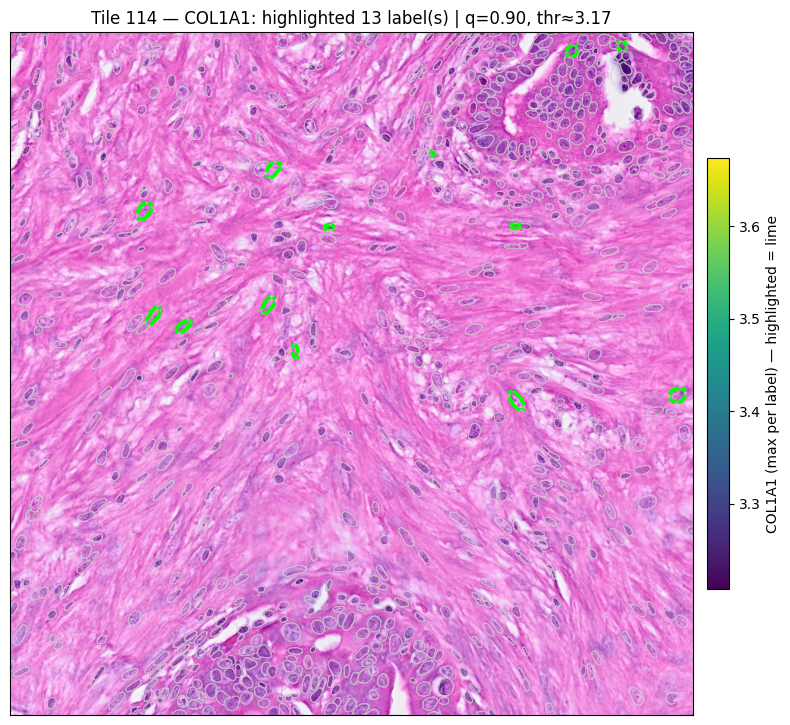

In [80]:
tile = tiles[114]  # or any valid tile id
tile_gene_all_boundaries(ctx, tile, gene="COL1A1",
                         expr_quantile=0.9,      # loosen if we want
                         top_n=500,
                         mode="outline",          # or fill
                         highlight_color="lime",
                         highlight_width=2.5,
                         all_edges_color="lightgray",
                         all_edges_alpha=0.7,
                         all_edges_width=0.6,
                         show_centroids=False)


In [81]:
# only labels above a threshold are highlighted in one color
#label outlines are color-mapped by expression (low→high)

def tile_gene_all_boundaries(ctx: B2CContext, tile, gene,
                             color_mode="binary",      # binary | gradient
                             expr_quantile=0.90,       # used as threshold in binary mode; as filter in gradient if not None
                             top_n=None,               # optional cap after ranking by expr
                             mode="outline",           # outline or fill (affects highlighted/gradient layer)
                             search_radius=2,
                             # background (all nuclei)
                             all_edges_color="lightgray",
                             all_edges_alpha=0.6,
                             all_edges_width=0.6,
                             # binary highlight style
                             highlight_color="lime",
                             highlight_width=2.5,
                             # gradient style
                             cmap_name="viridis",
                             vmin=None, vmax=None,
                             show_centroids=False):
    """
    H&E + ALL nuclei boundaries, plus gene layer as either:
      - binary: one highlight color for labels above expr_quantile
      - gradient: color each label by expression (continuous colormap)

    Expression per label = max(cell expression) among cells whose centroids map to that label.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection
    from matplotlib import colors, cm
    from skimage import measure
    from skimage.segmentation import find_boundaries

    assert color_mode in ("binary", "gradient")

    r0,r1,c0,c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    he, lab = ctx.crop_rc(r0, r1, c0, c1)
    present = np.unique(lab); present = present[present > 0]
    if present.size == 0:
        raise RuntimeError("No labels in this tile.")

    # dense gene vector
    Xg = ctx.adata[:, gene].X
    try: Xg = Xg.toarray()
    except: pass
    Xg = np.asarray(Xg).ravel()

    # cells in tile
    in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
    if not np.any(in_tile):
        raise RuntimeError("No cells (centroids) in this tile region.")

    rows_t = ctx.rows[in_tile] - r0
    cols_t = ctx.cols[in_tile] - c0
    vals_t = Xg[in_tile]

    # centroid -> label (with tiny neighborhood search)
    def nearest_label(rr, cc, sr=search_radius):
        lbl = lab[rr, cc]
        if lbl > 0 or sr <= 0:
            return lbl
        rr0 = max(rr - sr, 0); rr1 = min(rr + sr + 1, lab.shape[0])
        cc0 = max(cc - sr, 0); cc1 = min(cc + sr + 1, lab.shape[1])
        sub = lab[rr0:rr1, cc0:cc1]
        nz = sub[sub > 0]
        return np.bincount(nz).argmax() if nz.size else 0

    # aggregate per-label expression (max)
    lab_expr = {}
    for rr, cc, v in zip(rows_t, cols_t, vals_t):
        if rr < 0 or cc < 0 or rr >= lab.shape[0] or cc >= lab.shape[1]:
            continue
        lbl = nearest_label(rr, cc)
        if lbl <= 0: 
            continue
        if (lbl not in lab_expr) or (v > lab_expr[lbl]):
            lab_expr[lbl] = v

    # choose the label set to render
    labels_all = np.array(sorted(lab_expr.keys()), dtype=int)

    # thresholding / ranking
    thr = None
    if expr_quantile is not None and labels_all.size > 0:
        
        # quantile computed over cells in tile (vals_t) OR over labels? Here: over label values for selection.
        thr = np.quantile(np.array(list(lab_expr.values())), expr_quantile)
    if color_mode == "binary":
        if expr_quantile is None:
            # if no threshold provided, keep top 10% by default
            expr_quantile = 0.90
            thr = np.quantile(np.array(list(lab_expr.values())), expr_quantile)
        keep_labels = labels_all[np.array([lab_expr[l] > thr for l in labels_all])]
    else:  # gradient
        # optionally filter out the very lowest labels if expr_quantile set; otherwise keep all
        keep_mask = np.ones(labels_all.shape[0], dtype=bool)
        if thr is not None:
            keep_mask = np.array([lab_expr[l] > thr for l in labels_all])
        keep_labels = labels_all[keep_mask]

    if keep_labels.size == 0:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(he, zorder=0)
        edges = find_boundaries(lab, mode="inner")
        ax.contour(edges, levels=[0.5], colors=all_edges_color,
                   linewidths=all_edges_width, alpha=all_edges_alpha, zorder=1)
        ax.set_title(f"Tile {tile['id']} — {gene}: 0 labels pass filter"
                     + (f" (q={expr_quantile:.2f}, thr≈{thr:.3g})" if thr is not None else ""))
        ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout(); plt.show()
        return

    # optional top-N cap (for selection top 100 or 200 etc)
    if top_n is not None and keep_labels.size > top_n:
        ranked = sorted(keep_labels, key=lambda l: lab_expr[l], reverse=True)[:top_n]
        keep_labels = np.array(ranked, dtype=int)

    # prepare color mapping
    if color_mode == "gradient":
        vals = np.array([lab_expr[l] for l in keep_labels], dtype=float)
        if vmin is None or vmax is None:
            if vals.size > 5:
                vmin, vmax = np.percentile(vals, [2, 98])
            else:
                vmin, vmax = float(vals.min()), float(vals.max())
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.get_cmap(cmap_name)

    #  plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(he, zorder=0)

    # ALL nuclei boundaries (context)
    edges = find_boundaries(lab, mode="inner")
    ax.contour(edges, levels=[0.5], colors=all_edges_color,
               linewidths=all_edges_width, alpha=all_edges_alpha, zorder=1)

    # Gene layer
    if mode == "fill":
        # build list of values for fill
        lut = np.full(int(lab.max())+1, np.nan, dtype=float)
        for lbl in keep_labels:
            lut[lbl] = lab_expr[lbl]
        if color_mode == "binary":
            # binary fill renders with two alpha levels using a single color map band
            # show fill in highlight_color hue via a simple trick: map to 1 and use a ListedColormap
            from matplotlib.colors import ListedColormap
            cm_bin = ListedColormap([ (0,0,0,0), (0,1,0,1) ])  # transparent vs green
            mask = ~np.isnan(lut[lab])
            ax.imshow(mask.astype(float), cmap=cm_bin, alpha=0.4, zorder=2)
        else:
            im = ax.imshow(lut[lab], cmap=cmap, norm=norm, alpha=0.5, zorder=2)
            cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label)")
    else:
        # outline mode
        if color_mode == "binary":
            
            lines = []
            for lbl in keep_labels:
                rr, cc = np.where(lab == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=highlight_color,
                                                 linewidths=highlight_width, zorder=3))
        else:
            # gradient outlines
            lines, line_colors = [], []
            for lbl in keep_labels:
                rr, cc = np.where(lab == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
                    line_colors.append(cmap(norm(lab_expr[lbl])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=line_colors,
                                                 linewidths=highlight_width, zorder=3))
            sm = cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
            cb = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label)")

    if show_centroids:
        # show only centroids of kept labels, for clarity
        kset = set(keep_labels.tolist())
        rr_keep, cc_keep = [], []
        for rr, cc in zip(rows_t, cols_t):
            lbl = lab[rr, cc]
            if lbl in kset:
                rr_keep.append(rr); cc_keep.append(cc)
        ax.scatter(cc_keep, rr_keep, s=8, facecolors='none', edgecolors='cyan', linewidths=0.6, zorder=4)

    title = f"Tile {tile['id']} — {gene} | mode={color_mode}"
    if color_mode == "binary" and expr_quantile is not None and thr is not None:
        title += f" (q={expr_quantile:.2f}, thr≈{thr:.3g})"
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()


/tmp/ipykernel_3379477/3143851793.py:127: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


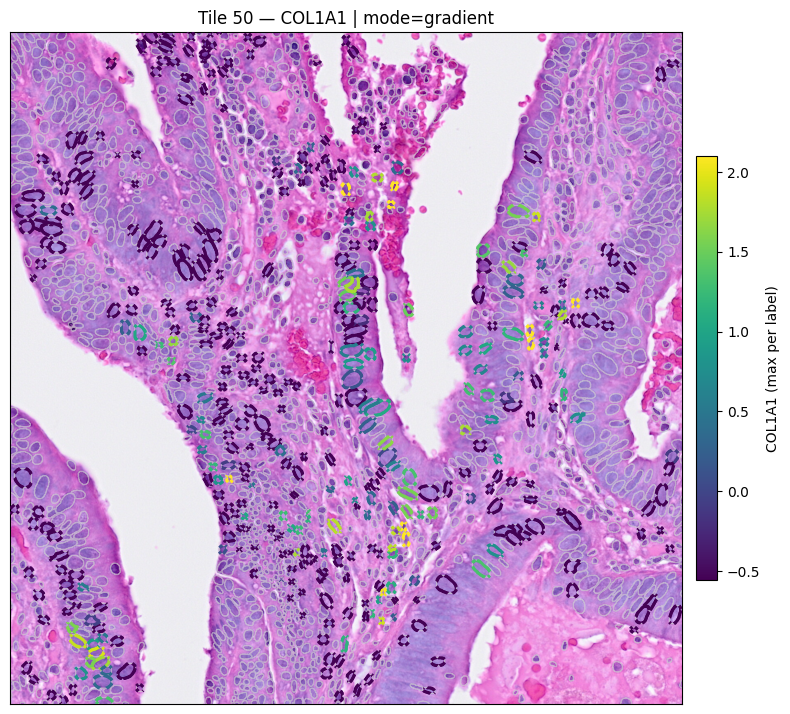

In [82]:
# Binary highlights of gene expression
# tile = tiles[114]
# tile_gene_all_boundaries(ctx, tile, gene="COL1A1",
#                          color_mode="binary",
#                          expr_quantile=0.90,
#                          mode="outline",           # or "fill"
#                          highlight_color="lime",
#                          highlight_width=2.5)


# gradient colrong of gene expression 
tile = tiles[50]
tile_gene_all_boundaries(ctx, tile, gene="COL1A1",
                         color_mode="gradient",
                         expr_quantile=None,       # keep all labels with any mapped cells
                         mode="outline",           # or "fill" for heatmap fill
                         cmap_name="viridis",
                         highlight_width=2.2)




In [83]:
def tile_gene_all_boundaries(ctx: B2CContext, tile, gene,
                             color_mode="gradient",      # gradient" | binary
                             expr_quantile=None,         # None = keep all labels with any mapped cells
                             top_n=None,
                             mode="outline",             # outline | fill (for the gene layer)
                             search_radius=2,
                             #  all nuceli outlines ( context) 
                             all_nuclei_outline=True,
                             all_edges_color="lightgray",
                             all_edges_alpha=0.7,
                             all_edges_width=0.6,
                             #  binary highlight style
                             highlight_color="lime",
                             highlight_width=2.5,
                             #  gradient style 
                             cmap_name="viridis",
                             vmin=None, vmax=None,
                             show_centroids=False):

    assert color_mode in ("gradient", "binary")

    r0,r1,c0,c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    he, lab = ctx.crop_rc(r0, r1, c0, c1)
    present = np.unique(lab); present = present[present > 0]
    if present.size == 0:
        raise RuntimeError("No labels in this tile.")

    # dense gene vector
    Xg = ctx.adata[:, gene].X
    try: Xg = Xg.toarray()
    except: pass
    Xg = np.asarray(Xg).ravel()

    # cells in tile
    in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
    if not np.any(in_tile):
        raise RuntimeError("No cells (centroids) in this tile region.")

    rows_t = ctx.rows[in_tile] - r0
    cols_t = ctx.cols[in_tile] - c0
    vals_t = Xg[in_tile]

    # centroid -> label
    def nearest_label(rr, cc):
        lbl = lab[rr, cc]
        if lbl > 0 or search_radius <= 0:
            return lbl
        rr0 = max(rr - search_radius, 0); rr1 = min(rr + search_radius + 1, lab.shape[0])
        cc0 = max(cc - search_radius, 0); cc1 = min(cc + search_radius + 1, lab.shape[1])
        sub = lab[rr0:rr1, cc0:cc1]
        nz = sub[sub > 0]
        return np.bincount(nz).argmax() if nz.size else 0

    # max expr per label
    lab_expr = {}
    for rr, cc, v in zip(rows_t, cols_t, vals_t):
        if rr < 0 or cc < 0 or rr >= lab.shape[0] or cc >= lab.shape[1]:
            continue
        lbl = nearest_label(rr, cc)
        if lbl <= 0: 
            continue
        if (lbl not in lab_expr) or (v > lab_expr[lbl]):
            lab_expr[lbl] = v

    labels_all = np.array(sorted(lab_expr.keys()), dtype=int)

    # threshold for selection (used by binary; optional prefilter for gradient)
    thr = None
    if expr_quantile is not None and labels_all.size:
        thr = np.quantile(np.array(list(lab_expr.values())), expr_quantile)

    if color_mode == "binary":
        if expr_quantile is None:  # sensible default
            expr_quantile = 0.90
            thr = np.quantile(np.array(list(lab_expr.values())), expr_quantile)
        keep_labels = labels_all[np.array([lab_expr[l] > thr for l in labels_all])]
    else:  # gradient
        if thr is None:
            keep_labels = labels_all
        else:
            keep_labels = labels_all[np.array([lab_expr[l] > thr for l in labels_all])]

    if keep_labels.size == 0:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(he, zorder=0)
        if all_nuclei_outline:
            edges = find_boundaries(lab, mode="inner")
            ax.contour(edges, levels=[0.5], colors=all_edges_color,
                       linewidths=all_edges_width, alpha=all_edges_alpha, zorder=1)
        ax.set_title(f"Tile {tile['id']} — {gene}: 0 labels pass"
                     + (f" (q={expr_quantile:.2f}, thr≈{thr:.3g})" if thr is not None else ""))
        ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout(); plt.show()
        return

    if top_n is not None and keep_labels.size > top_n:
        keep_labels = np.array(sorted(keep_labels, key=lambda l: lab_expr[l], reverse=True)[:top_n], dtype=int)

    # gradient color scale
    if color_mode == "gradient":
        vals = np.array([lab_expr[l] for l in keep_labels], dtype=float)
        if vmin is None or vmax is None:
            if vals.size > 5:
                vmin, vmax = np.percentile(vals, [2, 98])
            else:
                vmin, vmax = float(vals.min()), float(vals.max())
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.get_cmap(cmap_name)

    #  plot 
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(he, zorder=0)

    # all nuclei outlines (context)
    if all_nuclei_outline:
        edges = find_boundaries(lab, mode="inner")
        ax.contour(edges, levels=[0.5], colors=all_edges_color,
                   linewidths=all_edges_width, alpha=all_edges_alpha, zorder=1)

    # gene overlays
    if mode == "fill":
        lut = np.full(int(lab.max())+1, np.nan, dtype=float)
        for lbl in keep_labels:
            lut[lbl] = lab_expr[lbl]
        if color_mode == "binary":
            from matplotlib.colors import ListedColormap
            cm_bin = ListedColormap([(0,0,0,0), (0,1,0,1)])  # transparent vs green
            mask = ~np.isnan(lut[lab])
            ax.imshow(mask.astype(float), cmap=cm_bin, alpha=0.4, zorder=2)
        else:
            im = ax.imshow(lut[lab], cmap=cmap, norm=norm, alpha=0.5, zorder=2)
            cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label)")
    else:  # outline mode
        if color_mode == "binary":
            lines = []
            for lbl in keep_labels:
                rr, cc = np.where(lab == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=highlight_color,
                                                 linewidths=highlight_width, zorder=3))
        else:
            lines, line_colors = [], []
            for lbl in keep_labels:
                rr, cc = np.where(lab == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
                    line_colors.append(cmap(norm(lab_expr[lbl])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=line_colors,
                                                 linewidths=highlight_width, zorder=3))
            sm = cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
            cb = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per label)")

    if show_centroids:
        kset = set(keep_labels.tolist())
        rr_keep, cc_keep = [], []
        for rr, cc in zip(rows_t, cols_t):
            lbl = lab[rr, cc]
            if lbl in kset:
                rr_keep.append(rr); cc_keep.append(cc)
        ax.scatter(cc_keep, rr_keep, s=8, facecolors='none', edgecolors='cyan', linewidths=0.6, zorder=4)

    title = f"Tile {tile['id']} — {gene} | color_mode={color_mode}"
    if color_mode == "binary" and expr_quantile is not None and thr is not None:
        title += f" (q={expr_quantile:.2f}, thr≈{thr:.3g})"
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()


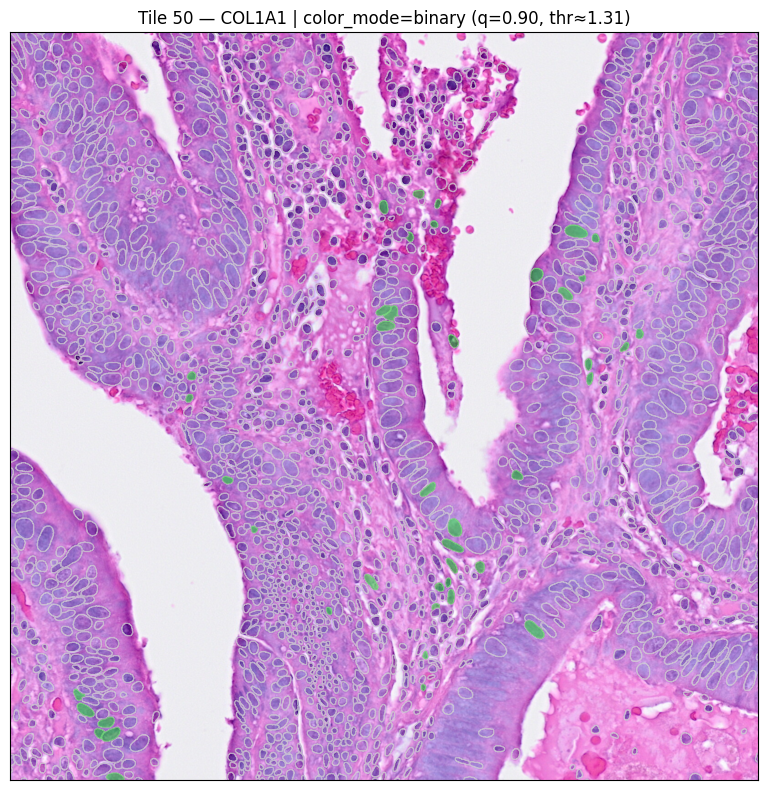

In [87]:
tile_gene_all_boundaries(ctx, tile, gene="COL1A1",
                         color_mode="binary", # or binary if you want specfic color
                         expr_quantile=0.9,  
                         top_n = 100, 
                         mode="fill",
                         cmap_name="viridis",
                         highlight_width=2.2,
                         all_nuclei_outline=True, # True or false outlines all nuclei
                         all_edges_color="lightgray",
                         all_edges_alpha=0.7,
                         all_edges_width=0.6)
